<a href="https://colab.research.google.com/github/Silentsky0/mn-project/blob/main/MACD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wskaźnik giełdowy MACD

### Paweł Cichowski
---

Celem projektu było zaimplementowanie wskaźnika giełdowego MACD.

Wskaźnik ten reprezentuje zbieżność/rozbieżność średnich kroczących ceny akcji.
Przebicie od dołu linii wskaźnika przez linię sygnału oznacza sygnał do kupna, zaś przebicie od góry linii wskaźnika jest sygnałem do sprzedaży.

W realizacji projektu wykorzystałem język Python, wspierając się bibliotekami Pandas, Matplotlib oraz NumPy.


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from datetime import datetime
from numpy import diff

### Dane do projektu

W projekcie wykorzystane zostały historyczne dane z akcji PKO na indeksie WIG20.

Dane pobrałem ze strony [Stooq](https://https://stooq.com), w formie pliku csv. Ilość danych ograniczyłem do ostatnich 1000 wartości z zamknięcia giełdy.

In [2]:
rawdata = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/macd/pko_d_longer.csv')

dataframe = pd.DataFrame(rawdata, columns= ['Date', 'Open', 'Close'])

dataframe = dataframe.tail(1000)

dataframe = dataframe.drop('Open', axis=1)

dataframe.rename(columns={ 'Close': 'Value'}, inplace=True)

Wykładnicza średnia krocząca liczona jest na podstawie wzoru podanego w materiałach zadania projektowego

\begin{align}
    EMA_N = \frac{p_0 + (1 − α)p_1 + (1 − α)^2p_2 + ··· + (1 − α)^N p_N}{1 (1− α) + (1 − α)^2 + ... + (1 − α)^N }
\end{align}

In [3]:
def calculate_ema(samples, num_of_periods):
    samples = samples[::-1] # reverse order
    samples = samples.head(num_of_periods + 1) # cut n first rows

    numerator = 0
    denominator = 0

    alpha = 2 / (num_of_periods + 1)

    for i in range(num_of_periods):
        denominator += (1 - alpha)**i

    for i, value in enumerate(samples['Value'].values): # vectorization
        numerator += value * (1 - alpha)**i

    return numerator / denominator

Na podstawie średnich kroczących 26- i 12-okresowych można obliczyć wykres MACD. Na podstawie 9-okresowej średniej z wykresu MACD liczony jest wykres SIGNAL

\begin{align}
    MACD = EMA_{12} - EMA_{26}\\[1em]
    SIGNAL = EMA(MACD)_9
\end{align}

In [4]:
def calculate_macd_indicator(samples):
    return calculate_ema(samples, 12) - calculate_ema(samples, 26)

def calculate_signal_indicator(samples):
    
    row_list = {'Date':[], 'Value':[]}
    for i in range(samples.shape[0] - 9, samples.shape[0]):
        samples = dataframe._slice(slice(0, i + 1)) # get current day and days before
        row_list['Date'].append(samples['Date'].iloc[-1])
        val = calculate_macd_indicator(samples)
        row_list['Value'].append(val)

    df = pd.DataFrame(row_list, columns=('Date', 'Value'))

    return calculate_ema(df, 9)

In [5]:
def calculate_indicators():
    indicators = {'day':[], 'price':[], 'MACD':[], 'SIGNAL':[]}  # vector of indicators and days

    start_day = 26
   
    for i in range(start_day, dataframe.shape[0]):
        samples = dataframe._slice(slice(0, i + 1)) # get current day and days before

        indicators['day'].append(samples['Date'].iloc[-1]) # current day
        indicators['price'].append(samples['Value'].iloc[-1]) # current closing price
        indicators['MACD'].append(calculate_macd_indicator(samples))
        indicators['SIGNAL'].append(calculate_signal_indicator(samples))

    return indicators

In [6]:
output = calculate_indicators()

day = output['day']
price = output['price']
macd = output['MACD']
signal = output['SIGNAL']


derivative = np.gradient(macd, 1)

derivative_above = derivative >= 0
derivative_below = derivative < 0

derivative_color = []
for val in derivative:
    if val < 0.0:
        derivative_color.append('red')
    elif val >= 0.0:
        derivative_color.append('green')

Wykresy stworzone zostały za pomocą bibliotek Matplotlib oraz datetime. Miejsca przecięcia są oznaczone czerwonymi kropkami - sygnał do kupna lub sprzedaży.

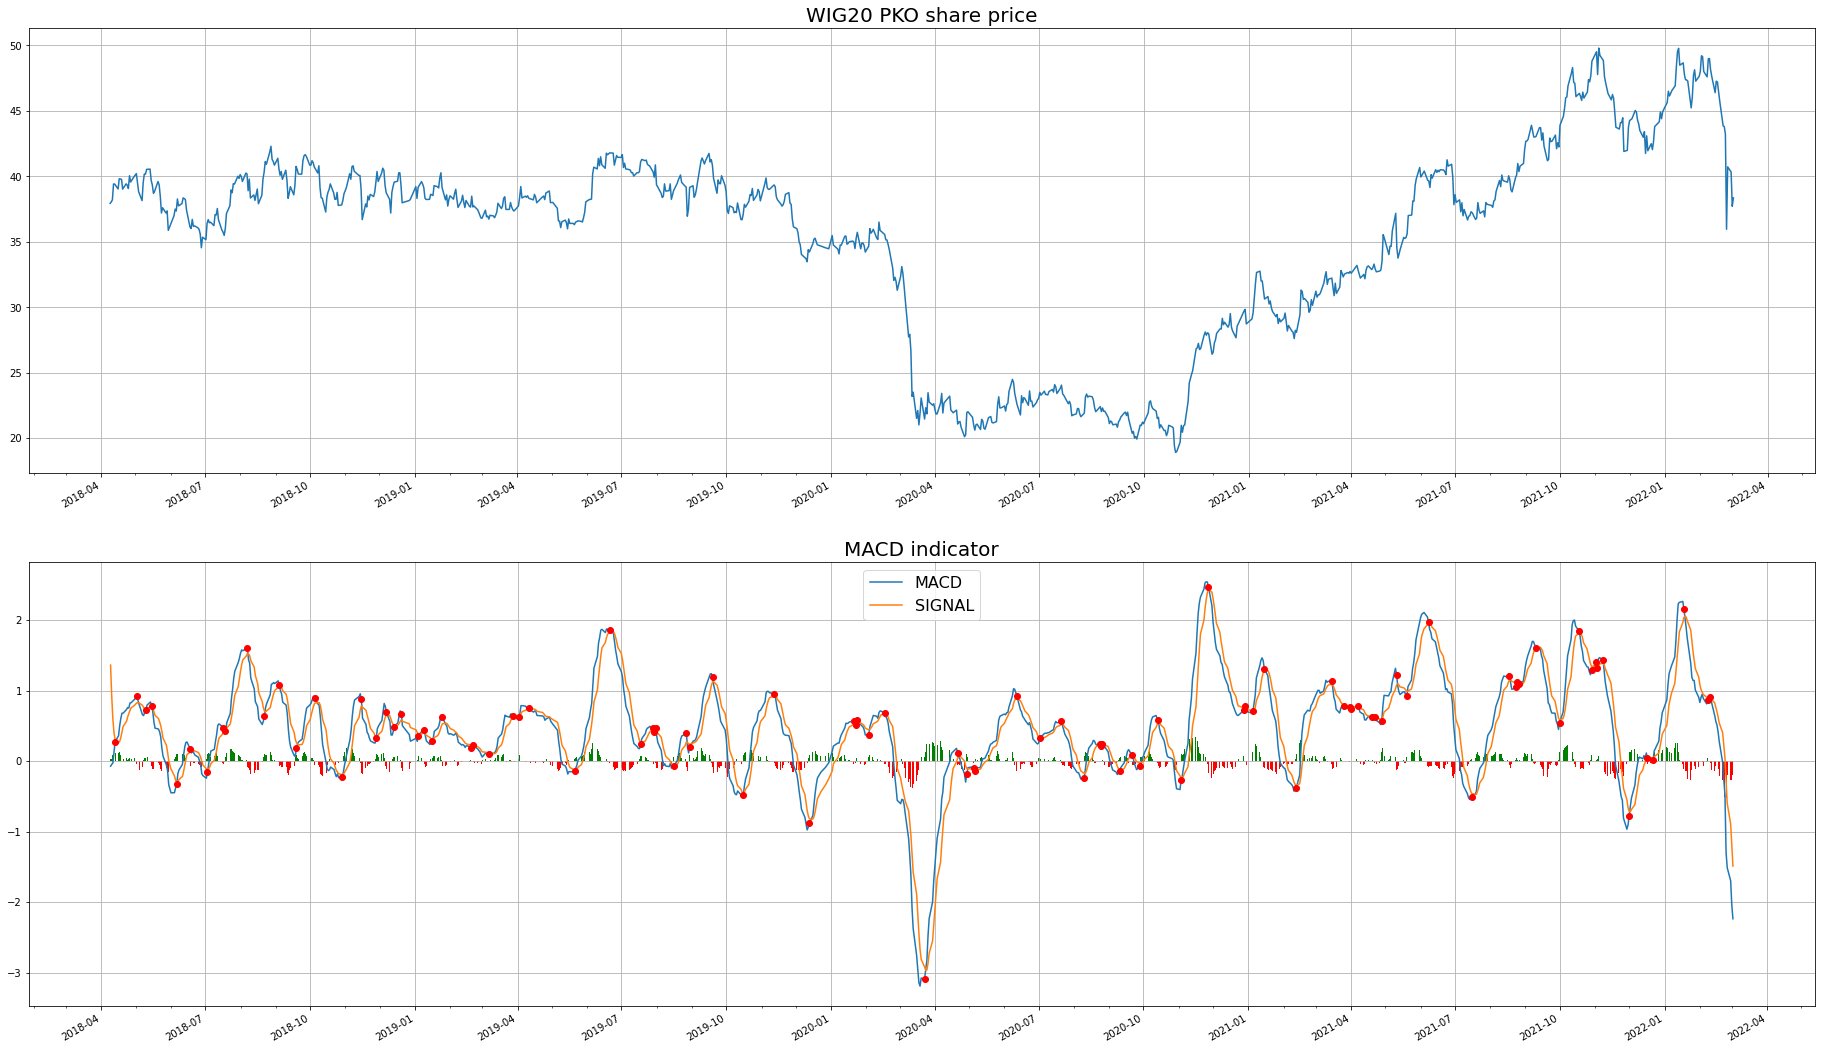

In [7]:
day = pd.to_datetime(day, format='%Y-%m') # convert to correct day format


fig, axs = plt.subplots(2, 1, figsize=(32, 18))


ax = axs[0]
ax.plot(day, price)
ax.set_title('WIG20 PKO share price', fontsize=20)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')


ax = axs[1]
ax.plot(day, macd, label="MACD")
ax.plot(day, signal, label="SIGNAL")
ax.bar(day, derivative, color=derivative_color)
ax.legend(loc='upper center', fontsize=16)

idx = np.argwhere(np.diff(np.sign(np.asarray(macd) - np.asarray(signal)))).flatten()
plt.plot(np.asarray(day)[idx], np.asarray(macd)[idx], 'ro')

ax.set_title('MACD indicator', fontsize=20)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')


plt.show()


# Weryfikacja przydatności wskaźnika MACD w analizie technicznej

Na powyższych wykresach przedstawione zostały wykresy ceny jednostki spółki PKOBP , MACD oraz SIGNAL.

Analizując punkty przecięcia, które mają sygnalizować sygnały do kupna lub sprzedaży, doszedłem do konkluzji, że wskaźnik ten oferuje zazwyczaj minimalne zyski lub straty. Kierując się wyłącznie wskaźnikiem MACD, nie jesteśmy gotowi na potencjalny krach giełdowy, tracąc długo zbierane, niewielkie zyski. 

Nie oznacza to, że wskaźnik MACD jest bezużyteczny. W niektórych sytuacjach prawie idealnie wskazał dobre okazje do zysków. Przykładem może być ostatni kwartał 2020 roku. Można zaobserwować wyraźny skok wskaźnika i ostateczne przecięcie, gdzie zazwyczaj oscyluje blisko zera. Może to implikować, że takie gwałtowne skoki są dobrym czasem do zaryzykowania.

Podsumowując, wskaźnik MACD nie jest przydatny w inwestycjach krótkoterminowych, oferując znikome i niepewne zyski. Jest natomiast pomocny w inwestycjach długoterminowych oraz w analizie technicznej.

